**1. Import Modules**

In [1]:
'''
  Import all necessary modules
'''

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Dense, Dropout, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam, Adadelta
from numpy.random import seed
from tensorflow.keras.utils import set_random_seed
from sklearn import preprocessing
import seaborn as sns

In [2]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
cd /content/gdrive/MyDrive/TRM/ENAAM

/content/gdrive/MyDrive/TRM/ENAAM


**2. Dataset Preparation**

In [72]:
# Import dataset
df = pd.read_csv('/content/gdrive/MyDrive/TRM/ENAAM/AllRanking/ground_truth-shuffled.csv')
df

,Response Time,Availability,Throughput,Reliability,Latency,Rank
0,182.25,67,9.7,67,46.50,1672
1,175.50,90,7.6,80,39.00,1585
2,500.71,92,2.2,67,233.85,2432
3,175.00,86,9.4,73,3.00,435
4,996.00,83,14.0,83,59.00,2088
...,...,...,...,...,...,...
2502,432.00,86,8.8,80,1.29,577
2503,249.00,56,8.1,73,2.25,554
2504,219.20,94,1.1,73,8.40,1256
2505,171.00,83,18.6,80,5.00,474


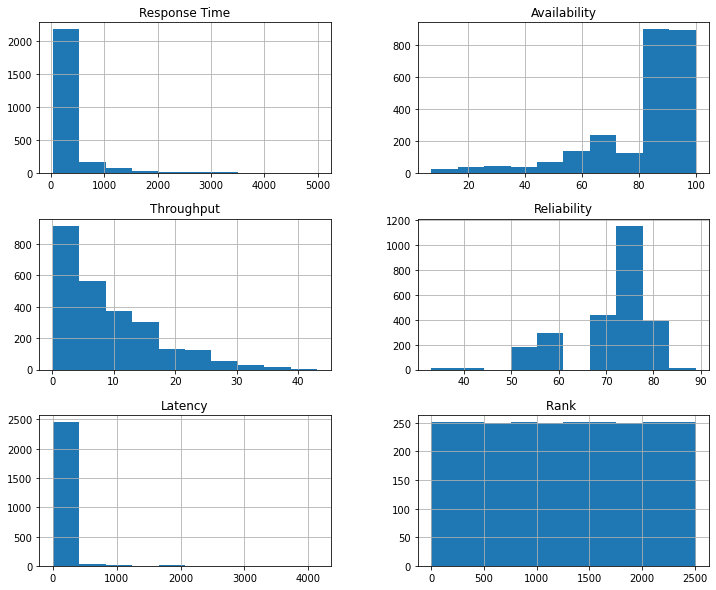

In [ ]:
df.hist(figsize = (12,10))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


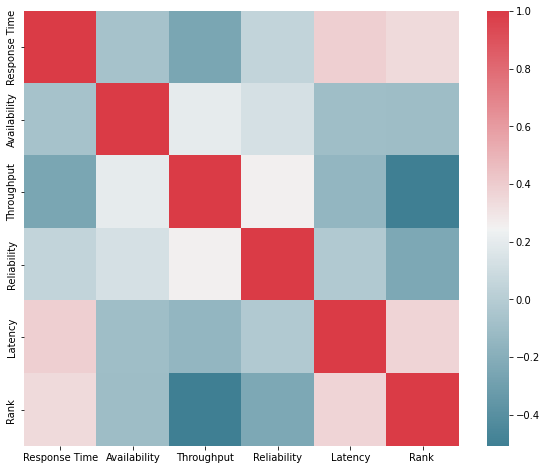

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

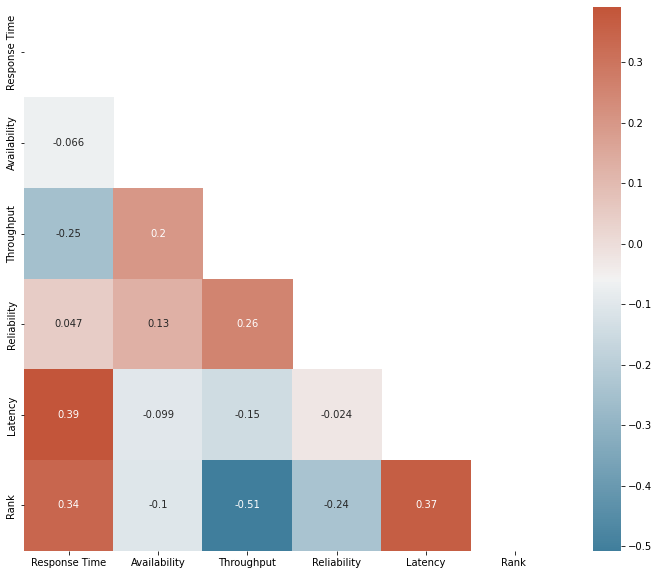

In [ ]:
# Correlation between different variables
#
corr = df.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [73]:
# Create python dataframe
decisions = pd.DataFrame()
decisions['Response Time'] = df['Response Time']
decisions['Availability'] = df['Availability']
decisions['Throughput'] = df['Throughput']
decisions['Reliability'] = df['Reliability']
decisions['Latency'] = df['Latency']
decisions['Rank'] = df['Rank ']
decisions


,Response Time,Availability,Throughput,Reliability,Latency,Rank
0,182.25,67,9.7,67,46.50,1672
1,175.50,90,7.6,80,39.00,1585
2,500.71,92,2.2,67,233.85,2432
3,175.00,86,9.4,73,3.00,435
4,996.00,83,14.0,83,59.00,2088
...,...,...,...,...,...,...
2502,432.00,86,8.8,80,1.29,577
2503,249.00,56,8.1,73,2.25,554
2504,219.20,94,1.1,73,8.40,1256
2505,171.00,83,18.6,80,5.00,474


In [74]:
'''
 Split dataset to train (70%), test (15%) and validation(15%) sets. 
 The top 30 values were removed from the dataset to be split. 
      * Reason for removal - We have to check the MAE of the top 30. The data should be unknown to the model to get
        accurate figures. 
'''
training_data = decisions[0:1785]#361

test_data = decisions[1855:2146]

validation_data = decisions[2146:2507]


In [75]:
# Split into input and output values

tmp_train = np.array(training_data)
X_train = tmp_train[:, :-1]
y_train = tmp_train[:, -1]

tmp_test = np.array(test_data)
X_test = tmp_test[:, :-1]
y_test = tmp_test[:, -1]

tmp_val = np.array(validation_data)
X_validation = tmp_val[:, :-1]
y_validation = tmp_val[:, -1]


**3. Model Preparation**

In [108]:
seed(0)
set_random_seed(0)

In [109]:
'''
 This function is used to display the training history of the dataset.
'''
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [110]:
# 3 hidden layer neural network 
model = Sequential()

n_cols = training_data.shape[1]

model.add(Dense(256, kernel_initializer='normal', activation='relu', input_shape=(5,)))
# The Hidden Layers :
model.add(Dense(128, kernel_initializer='normal',activation='relu'))
model.add(Dense(96, kernel_initializer='normal',activation='relu'))
model.add(Dense(72, kernel_initializer='normal',activation='relu'))

model.add(Dense(1))

In [111]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 256)               1536      
                                                                 
 dense_51 (Dense)            (None, 128)               32896     
                                                                 
 dense_52 (Dense)            (None, 96)                12384     
                                                                 
 dense_53 (Dense)            (None, 72)                6984      
                                                                 
 dense_54 (Dense)            (None, 1)                 73        
                                                                 
Total params: 53,873
Trainable params: 53,873
Non-trainable params: 0
_________________________________________________________________


In [112]:
'''
Checkpoints are used to save the model at some interval, so the model can be loaded from the saved state to continue training
'''
cp = ModelCheckpoint('model_ann_all/', save_best_only=True)

# Compile model
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0001), metrics='mean_absolute_error')


In [113]:
#train model

train_history = model.fit(X_train, y_train, epochs=500, validation_data=(X_validation, y_validation), callbacks=[cp])

Epoch 1/500
56/56 [==============================] - 2s 22ms/step - loss: 1250.1040 - mean_absolute_error: 1250.1040 - val_loss: 1239.1077 - val_mean_absolute_error: 1239.1077
Epoch 2/500
56/56 [==============================] - 1s 25ms/step - loss: 1179.2516 - mean_absolute_error: 1179.2516 - val_loss: 1045.9072 - val_mean_absolute_error: 1045.9072
Epoch 3/500
56/56 [==============================] - 1s 20ms/step - loss: 892.1691 - mean_absolute_error: 892.1691 - val_loss: 761.7283 - val_mean_absolute_error: 761.7283
Epoch 4/500
56/56 [==============================] - 1s 20ms/step - loss: 730.0883 - mean_absolute_error: 730.0883 - val_loss: 750.7408 - val_mean_absolute_error: 750.7408
Epoch 5/500
56/56 [==============================] - 1s 19ms/step - loss: 692.3908 - mean_absolute_error: 692.3908 - val_loss: 715.1630 - val_mean_absolute_error: 715.1630
Epoch 6/500
56/56 [==============================] - 1s 20ms/step - loss: 661.3474 - mean_absolute_error: 661.3474 - val_loss: 668.6

In [ ]:
# from tensorflow.keras.models import load_model   
# model = load_model('model_ann_all/')


In [114]:
#500
train_acc = model.evaluate(X_train, y_train, verbose=0)
print('MAE training : {:.3f}'.format(train_acc[1]))
scores = model.evaluate(X_validation, y_validation)
print('MAE validation : {:.3f}'.format(scores[1]))

test_acc = model.evaluate(X_test, y_test)
print('MAE test : {:.3f}'.format(test_acc[1]))

MAE training : 48.678
12/12 [==============================] - 0s 2ms/step - loss: 56.2526 - mean_absolute_error: 56.2526
MAE validation : 56.253
10/10 [==============================] - 0s 2ms/step - loss: 52.9920 - mean_absolute_error: 52.9920
MAE test : 52.992


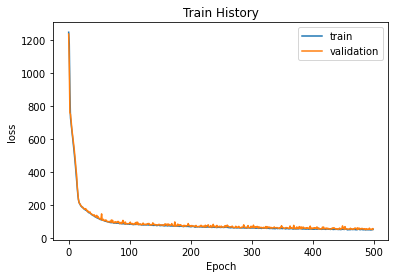

In [115]:
#500
show_train_history(train_history,'loss','val_loss')

**Results for 700 epochs**

In [116]:
train_predictions = model.predict(X_train).flatten()
#train_predict_round = np.rint(train_predictions)
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train.flatten()})
train_results

###train_results.to_csv(r'/content/gdrive/MyDrive/TRM/ENAAM/AllRanking/Predictions_Test_Top_Results_ANN.csv')
###train_results

56/56 [==============================] - 0s 1ms/step


,Train Predictions,Actuals
0,1558.797974,1672.0
1,1654.884644,1585.0
2,2536.983398,2432.0
3,437.166321,435.0
4,2182.268311,2088.0
...,...,...
1780,1096.386841,1104.0
1781,2356.502441,2506.0
1782,154.021698,162.0
1783,525.446838,532.0


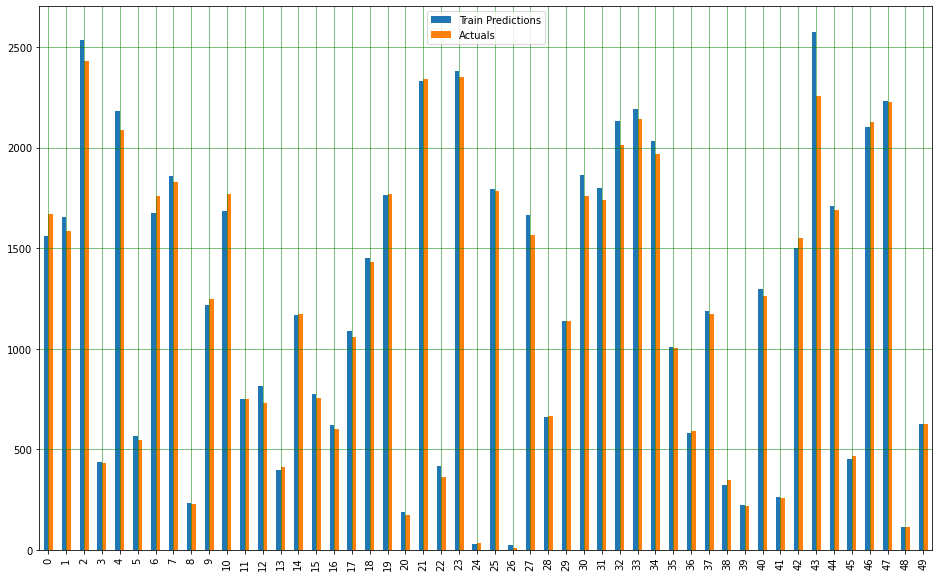

In [117]:
res1 = train_results.head(50)
res1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [118]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test.flatten()})
test_results

10/10 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,1521.840210,1517.0
1,562.586609,583.0
2,822.618530,812.0
3,484.921814,543.0
4,1838.764771,1809.0
...,...,...
286,2403.320801,2338.0
287,1007.237732,978.0
288,522.607971,514.0
289,281.693237,269.0


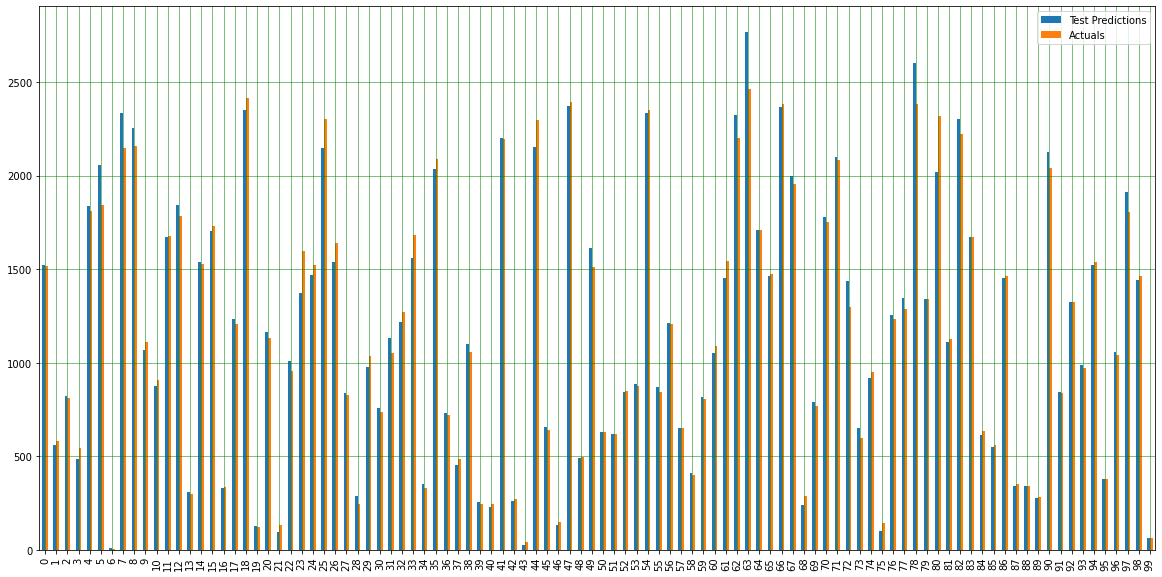

In [120]:
res2 = test_results.head(100)
res2.plot(kind='bar',figsize=(20,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

TOP 100

In [121]:
# Import dataset
df_2 = pd.read_csv('/content/gdrive/MyDrive/TRM/ENAAM/AllRanking/ground_truth.csv')
df_2

,Response Time,Availability,Throughput,Reliability,Latency,Rank
0,41.00,97,43.1,73,1.00,1
1,57.00,98,34.6,73,1.00,2
2,57.00,86,40.1,73,1.00,3
3,78.00,100,35.3,67,1.00,4
4,78.00,92,36.9,73,1.00,5
...,...,...,...,...,...,...
2502,1674.00,55,0.8,67,1005.40,2503
2503,2555.00,83,0.3,73,2035.00,2504
2504,2204.38,66,0.7,73,2050.13,2505
2505,4480.80,52,1.0,50,1652.40,2506


In [122]:
# Create python dataframe
decisions_2 = pd.DataFrame()
decisions_2['Response Time'] = df_2['Response Time']
decisions_2['Availability'] = df_2['Availability']
decisions_2['Throughput'] = df_2['Throughput']
decisions_2['Reliability'] = df_2['Reliability']
decisions_2['Latency'] = df_2['Latency']
decisions_2['Rank'] = df_2['Rank ']
decisions_2.head(100)

,Response Time,Availability,Throughput,Reliability,Latency,Rank
0,41.00,97,43.1,73,1.00,1
1,57.00,98,34.6,73,1.00,2
2,57.00,86,40.1,73,1.00,3
3,78.00,100,35.3,67,1.00,4
4,78.00,92,36.9,73,1.00,5
...,...,...,...,...,...,...
95,53.00,83,14.5,73,2.00,96
96,116.00,98,16.7,67,1.33,97
97,126.67,94,9.5,73,0.67,98
98,119.00,83,10.7,73,1.00,99


In [123]:
test_data_top = decisions_2[0:100]

In [124]:
tmp_top = np.array(test_data_top)
X_test_top = tmp_top[:, :-1]
y_test_top = tmp_top[:, -1]

In [125]:
test_acc_top = model.evaluate(X_test_top, y_test_top)
print('MAE test top : {:.3f}'.format(test_acc_top[1]))

4/4 [==============================] - 0s 3ms/step - loss: 7.0500 - mean_absolute_error: 7.0500
MAE test top : 7.050


In [126]:
test_predictions_top = model.predict(X_test_top).flatten()
test_results_top = pd.DataFrame(data={'Test Predictions':test_predictions_top, 'Actuals':y_test_top.flatten()})
test_results_top.to_csv(r'/content/gdrive/MyDrive/TRM/ENAAM/AllRanking/Predictions_Test_Top_Results_ANN.csv')
test_results_top

4/4 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,0.574440,1.0
1,-1.068486,2.0
2,4.985174,3.0
3,1.447594,4.0
4,6.912106,5.0
...,...,...
95,101.953537,96.0
96,72.762810,97.0
97,85.883667,98.0
98,118.695068,99.0


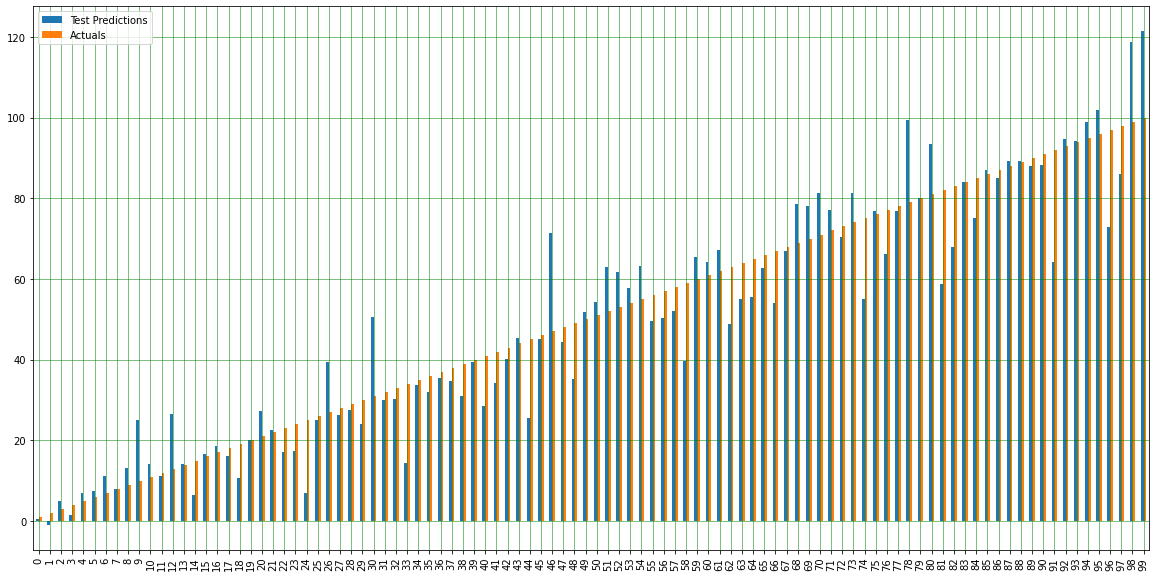

In [127]:
res3 = test_results_top.head(100)
res3.plot(kind='bar',figsize=(20,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()